In this notebook I will be using bayes_opt, a general purpose bayesian optimization framework to optimize hyperparameters of a fastai tabular learner with categorical embedding layers. I will do my best to account for the evaluation metric along the way. The links to the notebooks which this is based on, including Jeremy Howard's lecture, Zachary Mueller's repo and the bayes_opt repo as well as some other resources are provided at the end.

In [1]:
##Import the required packages. These include pandas, numpy,scikit-learn and optuna
!pip install bayesian-optimization -q
from bayes_opt import BayesianOptimization
from fastai.tabular.all import *
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import fastai


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-mar-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-mar-2021/train.csv
/kaggle/input/tabular-playground-series-mar-2021/test.csv


I read the train set, test set to be loaded to the python runtime.


In [2]:
train_ = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2021/train.csv')
test_ = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2021/test.csv')

In [3]:
train_.shape

(300000, 32)

Inspecting class imbalance. I will use stratfied sampling in train test split in a subsequent split to ensure this class imbalance is equally represented in the train and validation data sets.

In [4]:
from collections import Counter
Counter(train_['target'])

Counter({0: 220539, 1: 79461})

As a general rule of thumb, for exploratory work, I like to keep the mini batch size to around 1% of my training set size. Also ensure that you typecast the batch size to an integer, otherwise fastai will throw an error.

In [5]:
bs = int(train_.shape[0]*0.8/100)
bs

2400

Inspect the columns of the training data set 

In [6]:
train_.columns

Index(['id', 'cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7',
       'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15',
       'cat16', 'cat17', 'cat18', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4',
       'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'target'],
      dtype='object')

Get the feature+target columns of the training set and assign it to a different variable

In [7]:
df = train_[['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'target']]

Define a fit function that the Bayesian optimization framework will optimize. The hyperparameters we are optimizing for in this manner are the number of layers, the number of neurons per each such layer, learning rate, drop out and weight decay

Also I couldn't stress enough how important it is to pick the right metric to optimize. Since the competition guidelines specifically ask for auc and this is a binary target, RocAucBinary() is the approproate metric compatible with fastai here. Optimizing for accuracy might not lead to the best score in the confines of this tabular playground exercise.

In [8]:
def fit_with(lr:float, wd:float, dp:float, n_layers:float, layer_1:float, layer_2:float, layer_3:float):

  print(lr, wd, dp)
  if int(n_layers) == 2:
    layers = [int(layer_1), int(layer_2)]
  elif int(n_layers) == 3:
    layers = [int(layer_1), int(layer_2), int(layer_3)]
  else:
    layers = [int(layer_1)]
  config = tabular_config(embed_p=float(dp),
                          ps=float(wd))
  learn = tabular_learner(dls, layers=layers, metrics=RocAucBinary(), config = config)

  with learn.no_bar() and learn.no_logging():
    learn.fit(5, lr=float(lr))

  auc = float(learn.validate()[1])

  return auc

Assign lists of categorical variables and continuous variables to separate variables, specify preprocessing procs, the target and the correct type of data block for the target.

Notice that I do the train test split stratified on the target column

In [9]:
cat_names = ['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18']
cont_names = ['cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10']
procs = [Categorify, FillMissing, Normalize]
y_names = 'target'
y_block = CategoryBlock()
splits = TrainTestSplitter(test_size=0.2, random_state=42, stratify=df['target'])(range_of(df))

In [10]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names,
                   y_names=y_names, y_block=y_block, splits=splits)

In [11]:
dls = to.dataloaders(bs=bs)


Specify ranges for each of the hyperparameters discussed above. This is pretty much directly taken from Zachary Mueller's notebook. Feel free to play around with this but it's a good place to start.

In [12]:
hps = {'lr': (1e-05, 1e-01),
      'wd': (4e-4, 0.4),
      'dp': (0.01, 0.5),
       'n_layers': (1,3),
       'layer_1': (50, 200),
       'layer_2': (100, 1000),
       'layer_3': (200, 2000)}

Set up the optimizer and run the search. Note that we intend to maximize the auc so we seek for the maximum solution for 10 iterations

In [13]:
optim = BayesianOptimization(
    f = fit_with, # fit function as defined above
    pbounds = hps, # our hyper parameters 
    verbose = 3, 
    random_state=42
)
%time optim.maximize(n_iter=10) #Run the optimizer for 10 iterations

|   iter    |  target   |    dp     |  layer_1  |  layer_2  |  layer_3  |    lr     | n_layers  |    wd     |
-------------------------------------------------------------------------------------------------------------
0.01561030385783923 0.023610211422412507 0.19352465823520762


|  1        |  0.8876   |  0.1935   |  192.6    |  758.8    |  1.278e+0 |  0.01561  |  1.312    |  0.02361  |
0.09699128611767782 0.08525070862703915 0.4344263114297182


|  2        |  0.8831   |  0.4344   |  140.2    |  737.3    |  237.1    |  0.09699  |  2.665    |  0.08525  |
0.043200182414025165 0.24489641673106285 0.0990942339314793


|  3        |  0.8857   |  0.09909  |  77.51    |  373.8    |  1.145e+0 |  0.0432   |  1.582    |  0.2449   |
0.07851974437968744 0.2058880815900792 0.0783519917195005


|  4        |  0.882    |  0.07835  |  93.82    |  429.7    |  1.021e+0 |  0.07852  |  1.399    |  0.2059   |
0.006514508782598099 0.38626656041659396 0.3002831387424008


|  5        |  0.885    |  0.3003   |  56.97    |  646.8    |  506.9    |  0.006515 |  2.898    |  0.3863   |
0.0880907071028698 0.10312225179880781 0.17602350638717562


|  6        |  0.881    |  0.176    |  192.8    |  764.1    |  1.275e+0 |  0.08809  |  1.099    |  0.1031   |
0.07518834490613562 0.19932765454292467 0.04154169265570138


|  7        |  0.8817   |  0.04154  |  66.35    |  906.8    |  1.73e+03 |  0.07519  |  1.558    |  0.1993   |
0.09426328772291151 0.2722909136641639 0.21858882867861856


|  8        |  0.8824   |  0.2186   |  101.1    |  914.4    |  1.051e+0 |  0.09426  |  1.594    |  0.2723   |
0.07923910607866624 0.18598027201962777 0.49929258780251917


|  9        |  0.8822   |  0.4993   |  57.67    |  804.3    |  1.536e+0 |  0.07924  |  1.699    |  0.186    |
0.09661208267429061 0.011454215681021531 0.2824768254104184


|  10       |  0.5      |  0.2825   |  185.6    |  695.6    |  614.9    |  0.09661  |  1.792    |  0.01145  |
1e-05 0.0004 0.5


|  11       |  0.8744   |  0.5      |  139.0    |  677.4    |  1.391e+0 |  1e-05    |  3.0      |  0.0004   |
1e-05 0.0004 0.38143709535750236


|  12       |  0.8729   |  0.3814   |  174.9    |  612.9    |  1.227e+0 |  1e-05    |  2.301    |  0.0004   |
0.08619267164588613 0.246830525049531 0.3133913819652203


|  13       |  0.8844   |  0.3134   |  68.41    |  603.5    |  357.9    |  0.08619  |  2.643    |  0.2468   |
0.001416749885928521 0.05547000521613273 0.3364541844761861


|  14       |  0.8883   |  0.3365   |  54.62    |  807.8    |  1.542e+0 |  0.001417 |  2.237    |  0.05547  |
0.03641783347159078 0.2901881376570019 0.3366551346664063


|  15       |  0.8844   |  0.3367   |  58.94    |  982.8    |  1.554e+0 |  0.03642  |  2.716    |  0.2902   |
CPU times: user 3min 37s, sys: 2.84 s, total: 3min 40s
Wall time: 3min 38s


Let's inspect the best hyperparameters as discovered by our search

In [14]:
print(optim.max)


{'target': 0.8882793724615399, 'params': {'dp': 0.3364541844761861, 'layer_1': 54.616724182929104, 'layer_2': 807.8243595262542, 'layer_3': 1541.5251729166685, 'lr': 0.001416749885928521, 'n_layers': 2.237192244004574, 'wd': 0.05547000521613273}}


For the sake of brevity I only ran this for 10 iterations on the Kaggle environment. I ran this in a gpu enabled Colab pro instance for 500 iterations and the best I managed to get was as follows.

In [15]:
params = {'target': 0.8899, 'params': {'dp': 0.118, 'layer_1': 172.7, 'layer_2': 198.3, 'layer_3': 1.934e+0, 'lr': 0.001991 , 'n_layers': 2.116, 'wd': 0.08398}}
params

{'target': 0.8899,
 'params': {'dp': 0.118,
  'layer_1': 172.7,
  'layer_2': 198.3,
  'layer_3': 1.934,
  'lr': 0.001991,
  'n_layers': 2.116,
  'wd': 0.08398}}

It's impossible to have bits and pieces/ fractional neuron numbers in an MLP. So this requires some interpretation. A cleaned up set of hyperparameters on my 500 iteration search is as follows

In [16]:
params = {'target': 0.8899,
 'params': {'dp': 0.118,
  'layer_1': 172,
  'layer_2': 198,
  'lr': 0.001991,
  'n_layers': 2,
  'wd': 0.08398}}

Let's train a tabular learner with these hyperparameters for a few cycles using fit one cycle using the discovered learning rate

In [17]:
config = tabular_config(embed_p=float(0.118),
                          ps=float(0.08398))
layers = [172,198]
dls = to.dataloaders(bs=bs)
learn = tabular_learner(dls, layers=layers, metrics=RocAucBinary(), config = config)


Let's see if the learning rate finder's estimation for the learning rate matches what we found using the bayesian hyperparameter search

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=3.6307804584503174)

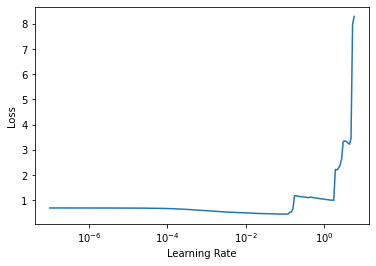

In [18]:
learn.lr_find(stop_div=False, num_it=200)


They don't particularly agree. However, in this case I will go with what we found in the hyperparamter search. I prefer not to risk going with too large a learning rate as it could risk overstepping global minima and bouncing around in the parameter space.

In [19]:
learn.fit_one_cycle(10,  0.001991)


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.406316,0.358901,0.885283,00:03
1,0.365541,0.356479,0.886565,00:02
2,0.358712,0.353471,0.887835,00:02
3,0.354123,0.352486,0.888256,00:02
4,0.351733,0.352626,0.889422,00:03
5,0.349477,0.351152,0.889622,00:02
6,0.346552,0.350374,0.889890,00:02
7,0.342852,0.349759,0.890426,00:02
8,0.340346,0.349482,0.890526,00:03
9,0.339591,0.349477,0.890571,00:03


Get the list of ids from the test set and subset the test_ dataframe for prediction with the trained tabular learner

In [20]:
test_df = test_[['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10']]

In [21]:
ids = test_.id.to_list()

In [22]:
dl = learn.dls.test_dl(test_df)
results = learn.get_preds(dl=dl)

In [23]:
predictions = []
for i in range(200000):
    predictions.append(int(np.argmax(results[0][i])))

    
    

Create the submission data set 

In [24]:
resultf = pd.DataFrame()
resultf['id'] = ids
resultf['target'] = predictions
resultf.to_csv('submission.csv', index=False)

In [25]:
resultf

,id,target
0,5,0
1,6,0
2,8,0
3,9,0
4,11,0
...,...,...
199995,499983,1
199996,499984,0
199997,499987,1
199998,499994,0


Some useful links:
Zachary Mueller's code:
https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Tabular%20Notebooks/02_Bayesian_Optimization.ipynb

Jeremy Howard's lesson:
https://course.fast.ai/videos/?lesson=7

Bayesian optimization framework used in this example:
https://github.com/fmfn/BayesianOptimization[](http://)
